# Continuous entropic barycenter estimation of MNIST 01 in data space

In [1]:
import torch
import torchvision
import torch.distributions as TD

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from tqdm import tqdm
import wandb
import os
import sys 
sys.path.append("/trinity/home/a.kolesov/Averaging-with-Energy-A-Generic-Algorithm-for-Continuous-Entropic-Barycenter-Estimation/")
from src.utils import Config, Distrib2Sampler, plot_barycenter_map_in_data_space
from src.eot_utils import computePotGrad, evaluating
from src.eot import sample_langevin_batch
from src.dgm_utils.statsmanager import StatsManager, StatsManagerDrawScheduler
from src.cost import cond_score, cost_l2_grad_y
from src.distributions import DatasetSampler
from src.resnet2 import  ResNet_D, weights_init_D

from typing import Callable, Tuple, Union

## 1. Parameters for Papermill

In [2]:
GPU_DEVICES = [0]
EPS = 0.01
LR = 1e-4
ENERGY_ITRS = 250
BATCH_SIZE = 128

## 2. Create Config

In [3]:
CONFIG = Config()

CONFIG.DATASET = 'mnist01'
CONFIG.DATASET_PATH  = '/trinity/home/a.kolesov/data/train_MNIST' 
CONFIG.BATCH_SIZE = BATCH_SIZE
CONFIG.CLASSES=[0,1]
CONFIG.IMG_SIZE=32
CONFIG.NC=1

CONFIG.ALPHAS_BARYCENTER = [.5, .5]
CONFIG.MAX_STEPS = 1000
CONFIG.K = len(CONFIG.ALPHAS_BARYCENTER)
CONFIG.HREG = EPS

CONFIG.LR = LR
CONFIG.CLIP_GRADS_NORM = False
CONFIG.BETAS = (0.2, 0.99)

CONFIG.LANGEVIN_THRESH = None
CONFIG.LANGEVIN_SAMPLING_NOISE = 0.1
CONFIG.ENERGY_SAMPLING_ITERATIONS = ENERGY_ITRS
CONFIG.LANGEVIN_DECAY = 1.0
CONFIG.LANGEVIN_SCORE_COEFFICIENT = 1.0
CONFIG.LANGEVIN_COST_COEFFICIENT = 1.0
 
CONFIG.BASIC_NOISE_VAR = 2.0
CONFIG.DEVICE =  f"cuda:{GPU_DEVICES[0]}"
CONFIG.DEVICES_IDS = GPU_DEVICES

CONFIG.NUM_TEST_RUNS = 4

## 3. Data samplers

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((CONFIG.IMG_SIZE, CONFIG.IMG_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: torch.clip(x,0,1))
])

data_samplers = []
 

for k in range(CONFIG.K):
    dataset = torchvision.datasets.MNIST(root=CONFIG.DATASET_PATH, download=True, 
                                         transform=transform)
    idx = [t == CONFIG.CLASSES[k] for t in dataset.targets]
    dataset.targets, dataset.data = np.array(dataset.targets)[idx], torch.tensor(dataset.data)[idx] 
    data_samplers.append(DatasetSampler(dataset,flag_label=True))

<ipython-input-4-9466d7103979>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset.targets, dataset.data = np.array(dataset.targets)[idx], torch.tensor(dataset.data)[idx]
/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 4. Potentials

In [5]:
f1 = ResNet_D(size=CONFIG.IMG_SIZE,
              nc=CONFIG.NC, nfilter=64, nfilter_max=512, res_ratio=0.1).to(CONFIG.DEVICE)
# f2 = - f1
weights_init_D(f1)
#f1 = DataParallelAttrAccess(f1,device_ids =CONFIG.DEVICES_IDS)
f1_opt = torch.optim.Adam(f1.parameters(), CONFIG.LR, betas=CONFIG.BETAS)

## 5. Preliminaries

In [6]:
def sample_langevin_mu_f(
        f: Callable[[torch.Tensor], torch.Tensor], 
        x: torch.Tensor, 
        y_init: torch.Tensor, 
        config: Config
    ) -> torch.Tensor:
    
    def score(y, ret_stats=False):
        return cond_score(f, cost_l2_grad_y, y, x, config, ret_stats=ret_stats)
    
    y, r_t, cost_r_t, score_r_t, noise_norm = sample_langevin_batch(
        score, 
        y_init,
        n_steps=config.ENERGY_SAMPLING_ITERATIONS, 
        decay=config.LANGEVIN_DECAY, 
        thresh=config.LANGEVIN_THRESH, 
        noise=config.LANGEVIN_SAMPLING_NOISE, 
        data_projector=lambda x: x, 
        compute_stats=True)
    
    return y

## 6. Training

In [7]:
wandb.init(project="MNIST_01_barycenter_in_data_space" ,
           name=f"EPS_{CONFIG.HREG}_LR_{CONFIG.LR}_BS_{CONFIG.BATCH_SIZE}_NS_{CONFIG.ENERGY_SAMPLING_ITERATIONS}" ,
           config=CONFIG)

wandb: Currently logged in as: emfalafeli (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.15.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
init_noise_sampler = Distrib2Sampler(TD.Normal(
    torch.zeros(CONFIG.NC,CONFIG.IMG_SIZE,CONFIG.IMG_SIZE).to('cpu'), 
    torch.ones(CONFIG.NC,CONFIG.IMG_SIZE,CONFIG.IMG_SIZE).to('cpu') * CONFIG.BASIC_NOISE_VAR))

  0%|          | 0/1 [00:00<?, ?it/s]

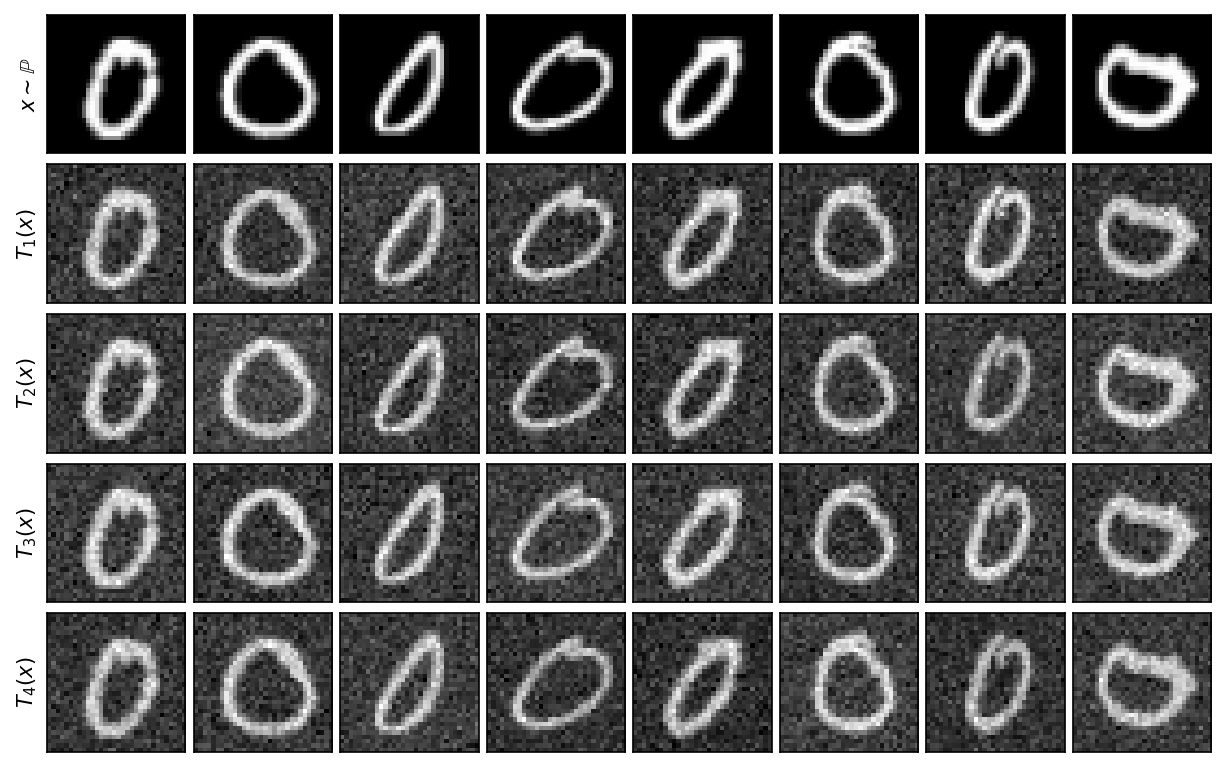

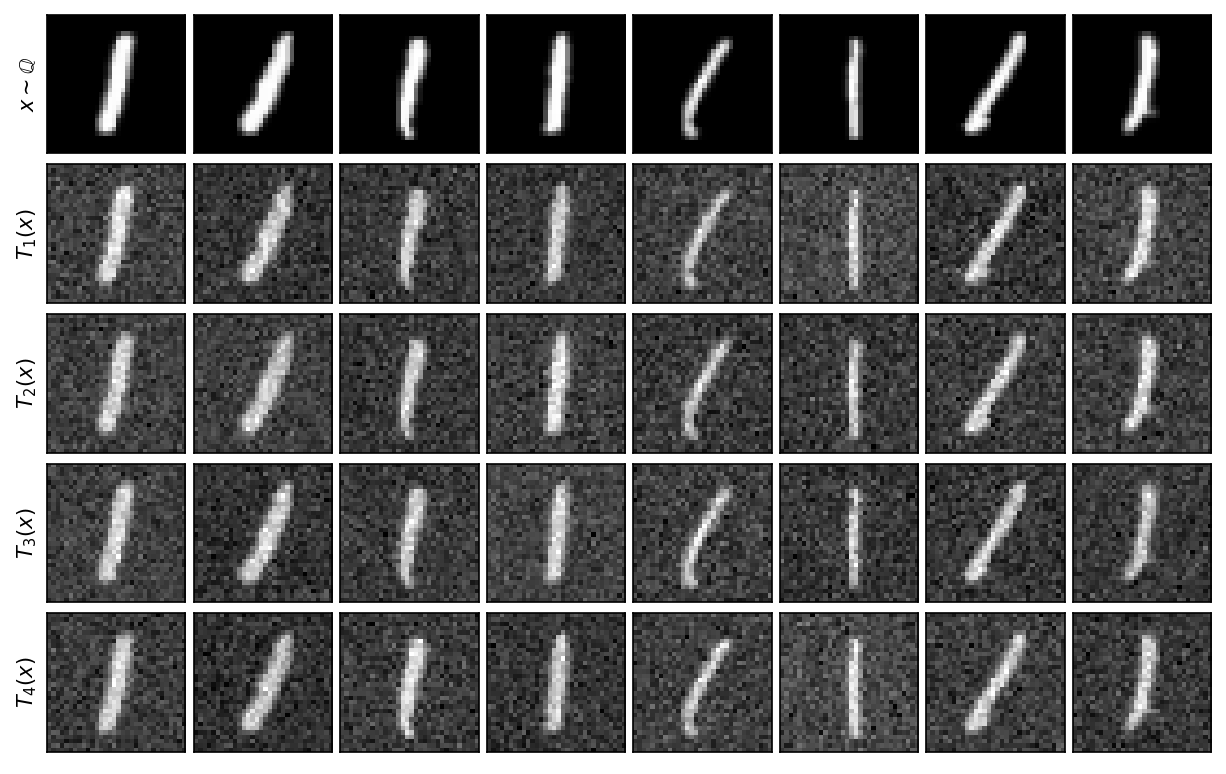

100%|██████████| 1/1 [00:17<00:00, 17.77s/it]


In [9]:
SMDS = StatsManagerDrawScheduler(StatsManager('loss'), 1, 1, (5, 4), epoch_freq=20)

for step in tqdm(range(CONFIG.MAX_STEPS)):
     
    f1.train(True)
    X1 = data_samplers[0].sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    X2 = data_samplers[1].sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    
    Y1_init = init_noise_sampler.sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    Y2_init = init_noise_sampler.sample(CONFIG.BATCH_SIZE).to(CONFIG.DEVICE)
    
    with evaluating(f1):
        Y1 = sample_langevin_mu_f(lambda x: f1(x), X1, Y1_init, CONFIG)
        Y2 = sample_langevin_mu_f(lambda x: -f1(x), X2, Y2_init, CONFIG)
        
    loss = CONFIG.ALPHAS_BARYCENTER[0]*f1(Y1).mean() - CONFIG.ALPHAS_BARYCENTER[1]*f1(Y2).mean()
    f1_opt.zero_grad(); loss.backward(); f1_opt.step()
    SMDS.SM.upd('loss', loss.item())
    SMDS.epoch()
    wandb.log({"loss train":loss.item()},step=step)
    
    with torch.no_grad():
        
        if step % 50 == 0:
            N_ESTIMATE_POINTS = 8
            X1 = data_samplers[0].sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE)
            X2 = data_samplers[1].sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE)
            with evaluating(f1):
                map_1 = []
                map_2 = []
                for run in range(CONFIG.NUM_TEST_RUNS):
                    Y1_init  = init_noise_sampler.sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE) 
                    Y2_init =  init_noise_sampler.sample(N_ESTIMATE_POINTS).to(CONFIG.DEVICE)
                    Y1 = sample_langevin_mu_f(lambda x: f1(x), X1, Y1_init, CONFIG)
                    Y2 = sample_langevin_mu_f(lambda x: -f1(x), X2, Y2_init, CONFIG)
                    map_1.append(Y1);map_2.append(Y2)
                    
            plot_barycenter_map_in_data_space(X1,X2,map_1,map_2, step=step,n_estimate_points=8)  
            
            with evaluating(f1):
                f1.to('cpu')
                torch.save(f1.cpu().state_dict(),f"/trinity/home/a.kolesov/Averaging-with-Energy-A-Generic-Algorithm-for-Continuous-Entropic-Barycenter-Estimation//ckpts/MNIST_0_1_in_data_space/f_1_it_{step}.pth")
                f1.to(CONFIG.DEVICE)
            

            

## 7. Save potrantial

In [10]:
torch.save(f1.state_dict(), os.path.join("/trinity/home/a.kolesov/",
           "Averaging-with-Energy-A-Generic-Algorithm-for-Continuous-Entropic-Barycenter-Estimation/",
           "ckpts/",
           f"MNIST_0_1_in_data_space/EPS_{CONFIG.HREG}_LR_{CONFIG.LR}_BS_{CONFIG.BATCH_SIZE}_NS_{CONFIG.ENERGY_SAMPLING_ITERATIONS}.pth")
          )
                 

wandb: 500 encountered ({"errors":[{"message":"graphql: panic occurred: runtime error: invalid memory address or nil pointer dereference","path":["project"]}],"data":{"project":null}}), retrying request
wandb: Network error resolved after 0:05:04.408163, resuming normal operation.
